In [1]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model, grid_search

import torch
import inference_helpers

import json

In [2]:
from importlib import reload
reload(inference_helpers)

<module 'inference_helpers' from 'c:\\Users\\obhlivoj\\DP\\System-Imbalance-Forecasting\\models\\transformer_future_lags\\inference_helpers.py'>

In [3]:
## randomized search
num_models = 1
best_model_params = []
for k in range(1, num_models+1):
    print(f"MODEL CROSS VALIDATING - #{k}")
    print(20*"--")
    config = get_config()

    param_grid = {
        "d_ff": [256, 512, 1024],
        "Nx": [4, 6],
        "n_head": [2],
        "dropout": [0.1, 0.2],
        "lr": [5*10**-2, 5*10**-3, 1*10**-3]
    }
    config["tgt_step"] = k-1

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    res, best_params, best_score = grid_search(config, device, lr_cv = None, n_epoch = 40, param_grid = param_grid, n_iter=18)
    best_model_params.append(best_params)
    print("Best params:", str(best_params))
    print(20*"--")

with open(f"{config['run']}_param.json", "w") as outfile: 
    json.dump({"params": param_grid, "best_params": best_model_params}, outfile)

MODEL CROSS VALIDATING - #1
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

hyperparams: d_ff: 1024, Nx: 4, n_head: 2, dropout: 0.1, lr: 0.005, 


  6%|▌         | 1/18 [38:12<10:49:34, 2292.64s/it]

Scores: 23849.36, 18433.79, 16962.72, 15992.80; avg score: 18809.67
--------------------
hyperparams: d_ff: 1024, Nx: 6, n_head: 2, dropout: 0.2, lr: 0.05, 


 11%|█         | 2/18 [1:31:09<12:30:06, 2812.94s/it]

Scores: 26295.33, 19956.31, 29306.76, 17510.24; avg score: 23267.16
--------------------
hyperparams: d_ff: 256, Nx: 6, n_head: 2, dropout: 0.2, lr: 0.05, 


 17%|█▋        | 3/18 [2:23:43<12:22:06, 2968.44s/it]

Scores: 26637.76, 18826.50, 38228.18, 17409.33; avg score: 25275.44
--------------------
hyperparams: d_ff: 256, Nx: 6, n_head: 2, dropout: 0.2, lr: 0.001, 


 22%|██▏       | 4/18 [3:16:18<11:49:52, 3042.35s/it]

Scores: 30583.86, 19511.71, 20182.59, 16565.92; avg score: 21711.02
--------------------
hyperparams: d_ff: 512, Nx: 4, n_head: 2, dropout: 0.1, lr: 0.001, 


 28%|██▊       | 5/18 [3:53:57<9:57:56, 2759.71s/it] 

Scores: 31124.16, 19324.04, 20838.82, 16690.69; avg score: 21994.43
--------------------
hyperparams: d_ff: 512, Nx: 4, n_head: 2, dropout: 0.2, lr: 0.005, 


 33%|███▎      | 6/18 [4:31:36<8:37:55, 2589.61s/it]

Scores: 25103.34, 18809.47, 18105.37, 16475.86; avg score: 19623.51
--------------------
hyperparams: d_ff: 1024, Nx: 6, n_head: 2, dropout: 0.1, lr: 0.005, 


 39%|███▉      | 7/18 [5:24:33<8:29:57, 2781.56s/it]

Scores: 22876.53, 17964.57, 16837.24, 16042.10; avg score: 18430.11
--------------------
hyperparams: d_ff: 512, Nx: 6, n_head: 2, dropout: 0.2, lr: 0.005, 


 44%|████▍     | 8/18 [6:18:08<8:06:33, 2919.36s/it]

Scores: 25410.67, 18593.22, 16884.70, 16445.75; avg score: 19333.59
--------------------
hyperparams: d_ff: 256, Nx: 6, n_head: 2, dropout: 0.2, lr: 0.005, 


 50%|█████     | 9/18 [7:10:44<7:29:01, 2993.46s/it]

Scores: 26414.62, 18416.00, 20243.98, 16078.73; avg score: 20288.33
--------------------
hyperparams: d_ff: 256, Nx: 6, n_head: 2, dropout: 0.1, lr: 0.05, 


 56%|█████▌    | 10/18 [8:03:26<6:46:04, 3045.53s/it]

Scores: 22766.40, 19166.08, 25221.47, 17340.43; avg score: 21123.59
--------------------
hyperparams: d_ff: 1024, Nx: 4, n_head: 2, dropout: 0.2, lr: 0.05, 


 61%|██████    | 11/18 [8:40:36<5:26:11, 2795.96s/it]

Scores: 22700.73, 20462.60, 68716.37, 17460.92; avg score: 32335.15
--------------------
hyperparams: d_ff: 1024, Nx: 6, n_head: 2, dropout: 0.1, lr: 0.001, 


 67%|██████▋   | 12/18 [9:33:12<4:50:32, 2905.46s/it]

Scores: 29477.18, 19374.09, 20970.62, 16444.83; avg score: 21566.68
--------------------
hyperparams: d_ff: 512, Nx: 4, n_head: 2, dropout: 0.2, lr: 0.001, 


 72%|███████▏  | 13/18 [10:11:04<3:46:08, 2713.69s/it]

Scores: 32199.08, 19774.11, 20996.33, 17009.54; avg score: 22494.76
--------------------
hyperparams: d_ff: 1024, Nx: 4, n_head: 2, dropout: 0.1, lr: 0.001, 


 78%|███████▊  | 14/18 [10:48:19<2:51:15, 2568.95s/it]

Scores: 30693.80, 19385.44, 19857.82, 16583.94; avg score: 21630.25
--------------------
hyperparams: d_ff: 512, Nx: 6, n_head: 2, dropout: 0.1, lr: 0.001, 


 83%|████████▎ | 15/18 [11:41:16<2:17:36, 2752.24s/it]

Scores: 31620.08, 18849.07, 19951.46, 16448.49; avg score: 21717.27
--------------------
hyperparams: d_ff: 512, Nx: 4, n_head: 2, dropout: 0.2, lr: 0.05, 


 89%|████████▉ | 16/18 [12:19:21<1:27:03, 2611.61s/it]

Scores: 24638.85, 20946.00, 39824.30, 17487.55; avg score: 25724.17
--------------------
hyperparams: d_ff: 1024, Nx: 4, n_head: 2, dropout: 0.2, lr: 0.001, 


 94%|█████████▍| 17/18 [12:56:16<41:32, 2492.39s/it]  

Scores: 31639.47, 19506.87, 21265.17, 17143.92; avg score: 22388.86
--------------------
hyperparams: d_ff: 256, Nx: 4, n_head: 2, dropout: 0.1, lr: 0.005, 


100%|██████████| 18/18 [13:33:26<00:00, 2711.49s/it]

Scores: 25391.95, 18930.79, 16690.48, 15837.59; avg score: 19212.70
--------------------
Best params: {'d_ff': 1024, 'Nx': 6, 'n_head': 2, 'dropout': 0.1, 'lr': 0.005}
----------------------------------------


In [6]:
best_params

{'d_ff': 1024, 'Nx': 6, 'n_head': 2, 'dropout': 0.1, 'lr': 0.005}

In [5]:
best_params =  {'d_ff': 1024, 'Nx': 6, 'n_head': 2, 'dropout': 0.1, 'lr': 0.005}

In [5]:
# final_1 best models
# 70, 55, 59, 43, 49, 39, 83

In [13]:
cfg = get_config()

if cfg['tgt_seq_len'] < cfg['val_seq_len']:
    raise ValueError("Tensors must have the same shape.")

print(f"MODEL TRAINING")
print(20*"-")
cfg['model_folder'] += cfg['run']
cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

cfg['preload'] = f'69'
cfg['num_epochs'] = 100

for param_name in best_params.keys():
    cfg[param_name] = best_params[param_name]

model, summary = train_model(cfg)
# save config to JSON
with open(f"{cfg['run']}.json", "w") as outfile: 
    json.dump(cfg, outfile)
print(20*"-")

MODEL TRAINING
--------------------
Using device: cuda
Preloading model weightsfinal_single_step\tmodel_69.pt


Processing Epoch 70: 100%|██████████| 626/626 [00:33<00:00, 18.81it/s, loss=24400.766]


Training loss of epoch 70: 16870.779693116016


100%|██████████| 14/14 [00:00<00:00, 19.97it/s]


Validation loss of epoch 70: 15062.359375


Processing Epoch 71: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=5835.684] 


Training loss of epoch 71: 16828.990805336463


100%|██████████| 14/14 [00:00<00:00, 20.11it/s]


Validation loss of epoch 71: 15105.1103515625


Processing Epoch 72: 100%|██████████| 626/626 [00:33<00:00, 18.85it/s, loss=42823.148]


Training loss of epoch 72: 16872.067294672273


100%|██████████| 14/14 [00:00<00:00, 20.29it/s]


Validation loss of epoch 72: 15039.6376953125


Processing Epoch 73: 100%|██████████| 626/626 [00:33<00:00, 18.83it/s, loss=7334.222] 


Training loss of epoch 73: 16767.4755469374


100%|██████████| 14/14 [00:00<00:00, 20.17it/s]


Validation loss of epoch 73: 15045.470703125


Processing Epoch 74: 100%|██████████| 626/626 [00:33<00:00, 18.90it/s, loss=17020.174]


Training loss of epoch 74: 16822.41549614367


100%|██████████| 14/14 [00:00<00:00, 15.00it/s]


Validation loss of epoch 74: 15043.078125


Processing Epoch 75: 100%|██████████| 626/626 [00:33<00:00, 18.87it/s, loss=34553.168]


Training loss of epoch 75: 16853.457669291634


100%|██████████| 14/14 [00:00<00:00, 20.32it/s]


Validation loss of epoch 75: 15059.2880859375


Processing Epoch 76: 100%|██████████| 626/626 [00:33<00:00, 18.84it/s, loss=28236.863]


Training loss of epoch 76: 16861.772201196836


100%|██████████| 14/14 [00:00<00:00, 24.76it/s]


Validation loss of epoch 76: 15119.390625


Processing Epoch 77: 100%|██████████| 626/626 [00:33<00:00, 18.87it/s, loss=7072.329] 


Training loss of epoch 77: 16800.29369025185


100%|██████████| 14/14 [00:00<00:00, 19.94it/s]


Validation loss of epoch 77: 15139.435546875


Processing Epoch 78: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=37360.820]


Training loss of epoch 78: 16816.27926177491


100%|██████████| 14/14 [00:00<00:00, 20.43it/s]


Validation loss of epoch 78: 15043.5068359375


Processing Epoch 79: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=27367.631]


Training loss of epoch 79: 16818.505650334464


100%|██████████| 14/14 [00:00<00:00, 24.67it/s]


Validation loss of epoch 79: 15105.0595703125


Processing Epoch 80: 100%|██████████| 626/626 [00:33<00:00, 18.85it/s, loss=5814.104] 


Training loss of epoch 80: 16798.376889944837


100%|██████████| 14/14 [00:00<00:00, 16.45it/s]


Validation loss of epoch 80: 15132.794921875


Processing Epoch 81: 100%|██████████| 626/626 [00:33<00:00, 18.87it/s, loss=16892.680]


Training loss of epoch 81: 16796.068044254193


100%|██████████| 14/14 [00:00<00:00, 24.62it/s]


Validation loss of epoch 81: 15080.8935546875


Processing Epoch 82: 100%|██████████| 626/626 [00:33<00:00, 18.82it/s, loss=5157.080] 


Training loss of epoch 82: 16745.93007360099


100%|██████████| 14/14 [00:00<00:00, 18.69it/s]


Validation loss of epoch 82: 15116.9306640625


Processing Epoch 83: 100%|██████████| 626/626 [00:33<00:00, 18.69it/s, loss=10679.318]


Training loss of epoch 83: 16728.532994084464


100%|██████████| 14/14 [00:00<00:00, 19.94it/s]


Validation loss of epoch 83: 15063.107421875


Processing Epoch 84: 100%|██████████| 626/626 [00:33<00:00, 18.84it/s, loss=6830.747] 


Training loss of epoch 84: 16826.73887873153


100%|██████████| 14/14 [00:00<00:00, 18.72it/s]


Validation loss of epoch 84: 15077.3642578125


Processing Epoch 85: 100%|██████████| 626/626 [00:33<00:00, 18.85it/s, loss=11896.141]


Training loss of epoch 85: 16774.10587045103


100%|██████████| 14/14 [00:00<00:00, 20.51it/s]


Validation loss of epoch 85: 15115.5517578125


Processing Epoch 86: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=15386.250]


Training loss of epoch 86: 16802.427729694988


100%|██████████| 14/14 [00:00<00:00, 24.67it/s]


Validation loss of epoch 86: 15068.6162109375


Processing Epoch 87: 100%|██████████| 626/626 [00:33<00:00, 18.79it/s, loss=23303.340]


Training loss of epoch 87: 16788.679142278605


100%|██████████| 14/14 [00:00<00:00, 20.29it/s]


Validation loss of epoch 87: 15061.5771484375


Processing Epoch 88: 100%|██████████| 626/626 [00:33<00:00, 18.85it/s, loss=28327.547]


Training loss of epoch 88: 16823.95109855481


100%|██████████| 14/14 [00:00<00:00, 19.50it/s]


Validation loss of epoch 88: 15060.90625


Processing Epoch 89: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=12484.022]


Training loss of epoch 89: 16779.79376903205


100%|██████████| 14/14 [00:00<00:00, 21.41it/s]


Validation loss of epoch 89: 15067.8759765625


Processing Epoch 90: 100%|██████████| 626/626 [00:33<00:00, 18.79it/s, loss=5106.708] 


Training loss of epoch 90: 16759.463061445436


100%|██████████| 14/14 [00:00<00:00, 20.84it/s]


Validation loss of epoch 90: 15076.4189453125


Processing Epoch 91: 100%|██████████| 626/626 [00:33<00:00, 18.82it/s, loss=13059.160]


Training loss of epoch 91: 16744.24475058656


100%|██████████| 14/14 [00:00<00:00, 19.81it/s]


Validation loss of epoch 91: 15059.8642578125


Processing Epoch 92: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=1678.611] 


Training loss of epoch 92: 16810.969606052193


100%|██████████| 14/14 [00:00<00:00, 24.23it/s]


Validation loss of epoch 92: 15063.60546875


Processing Epoch 93: 100%|██████████| 626/626 [00:33<00:00, 18.86it/s, loss=5437.005] 


Training loss of epoch 93: 16764.69862906849


100%|██████████| 14/14 [00:00<00:00, 20.09it/s]


Validation loss of epoch 93: 15051.7724609375


Processing Epoch 94: 100%|██████████| 626/626 [00:33<00:00, 18.86it/s, loss=15708.317]


Training loss of epoch 94: 16763.40750658322


100%|██████████| 14/14 [00:00<00:00, 19.47it/s]


Validation loss of epoch 94: 15043.298828125


Processing Epoch 95: 100%|██████████| 626/626 [00:33<00:00, 18.86it/s, loss=5826.760] 


Training loss of epoch 95: 16751.386723430012


100%|██████████| 14/14 [00:00<00:00, 18.62it/s]


Validation loss of epoch 95: 15053.6884765625


Processing Epoch 96: 100%|██████████| 626/626 [00:33<00:00, 18.88it/s, loss=11347.184]


Training loss of epoch 96: 16804.21439446885


100%|██████████| 14/14 [00:00<00:00, 19.61it/s]


Validation loss of epoch 96: 15028.7587890625


Processing Epoch 97: 100%|██████████| 626/626 [00:33<00:00, 18.82it/s, loss=9104.352] 


Training loss of epoch 97: 16721.45028501273


100%|██████████| 14/14 [00:00<00:00, 20.49it/s]


Validation loss of epoch 97: 15036.8623046875


Processing Epoch 98: 100%|██████████| 626/626 [00:33<00:00, 18.83it/s, loss=7764.339] 


Training loss of epoch 98: 16743.031123639677


100%|██████████| 14/14 [00:00<00:00, 21.40it/s]


Validation loss of epoch 98: 15028.4990234375


Processing Epoch 99: 100%|██████████| 626/626 [00:33<00:00, 18.84it/s, loss=14329.902]


Training loss of epoch 99: 16709.94293739392


100%|██████████| 14/14 [00:00<00:00, 20.55it/s]


Validation loss of epoch 99: 15039.630859375
--------------------


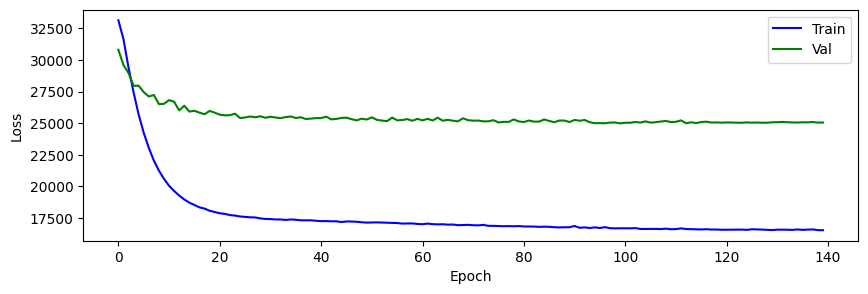

In [11]:
inference_helpers.arrange_figures_in_rows(n_rows=1, prefix="final_mod")